In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
drive_dir = '/content/drive/MyDrive'

Mounted at /content/drive/


In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
!ls /content/drive/MyDrive/
!mkdir /content/data

'2Y Team Report (1).gdoc'
'2Y Team Report.gdoc'
 age_intervals_one.json
 all_images.rar
 architectures
'Colab Notebooks'
'Copy of Farm spreadsheet V3.5.gsheet'
'Copy of Genshin Impact Checklist v3.3.gsheet'
'Copy of HonestlyFire'\''s Cookie Analysis (1).gsheet'
'Copy of HonestlyFire'\''s Cookie Analysis (2).gsheet'
'Copy of HonestlyFire'\''s Cookie Analysis (3).gsheet'
"Copy of HonestlyFire's Cookie Analysis.gsheet"
'Copy of NGU SPREADSHEET - MAKE A LOCAL COPY (1).gsheet'
'Copy of NGU SPREADSHEET - MAKE A LOCAL COPY.gsheet'
'Copy of [PDF] Student Statements.pdf'
'Copy of Talismans Checklist [2022].gsheet'
 dataframe.pkl
'GENSHIN 100%.gsheet'
 initial_splits_binary.json
 model_40.pth


In [ ]:
!!unrar x /content/drive/MyDrive/all_images.rar /content/data -idq

[]

# Imports

In [ ]:
%matplotlib inline

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import random
import json
import time
import os


import torch
import torchvision.transforms.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim.lr_scheduler import OneCycleLR
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

SEED = 42
EXP_COUNTER = 0

def plot_image(image, title="image", grayscale=False, axis=False):
    axis_toggle = "off" if not axis else "on"
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10,10))
    if not grayscale:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis(axis_toggle)

# Set random seed for PyTorch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Set random seed for NumPy
np.random.seed(SEED)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Age dataset iterable

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class AgeDataset(Dataset):
    # image_paths: list of image paths as strings
    # labels: list of labels as integers
    # resize: (channels, width, height) new image shape
    def __init__(self, image_paths, labels, resize=None, augmentations=None):
        self.num_samples = len(image_paths)
        self.image_paths = image_paths
        self.transform = augmentations
        self.labels = labels

        self.resize = resize
        if resize is not None:
            resize = list(resize)
            self.resize = [resize[x] for x in (1,2,0)]


    def __len__(self):
        return self.num_samples


    def __getitem__(self, item):
        image = Image.open(self.image_paths[item])
        image = image.convert("RGB")
        label = self.labels[item]

        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )

        if self.transform:
            image = self.transform(image)
        else:
            image = np.array(image)

            # transpose from 32x32x3 to 3x32x32
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            # image = image.permute()

        return image, label

# Importing initial train and test split, as well as the pandas dataframe.

20_0_0_20170117140056058.jpg


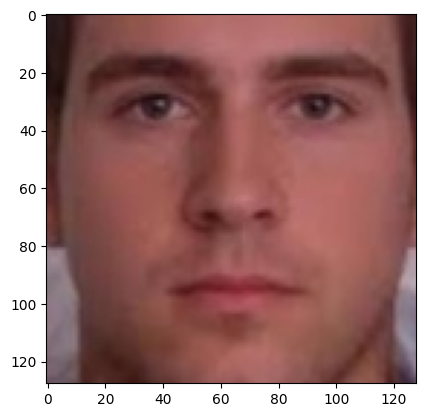

(128, 128, 3)


In [ ]:
base_dir = "/content/data/all_images"

img_path = os.listdir(base_dir)[0]
print(img_path)

img = Image.open(os.path.join(base_dir, img_path))

plt.imshow(img)
plt.show()
img = np.array(img.convert("RGB"))
print(img.shape)

In [ ]:
with open('/content/drive/MyDrive/age_intervals_one.json') as f:
  current_config = json.load(f)

current_config

{'0': [6, 15],
 '1': [16, 25],
 '2': [26, 35],
 '3': [36, 50],
 '4': [51, 65],
 '5': [66, 120]}

In [ ]:
with open('/content/drive/MyDrive/initial_splits_binary.json') as f:
    initial_splits = json.load(f)

with open('/content/drive/MyDrive/dataframe.pkl', 'rb') as f:
    df = pickle.load(f)

df = df.drop(columns=['hog_features'])
print(df)

                              name  age
0                       000002.jpg   80
1                       000003.jpg   50
2                       000004.jpg   17
3                       000005.jpg   27
4                       000006.jpg   24
...                            ...  ...
26846  9_1_0_20170110224621441.jpg    9
26847  9_1_0_20170117172655681.jpg    9
26848  9_1_0_20170117180006484.jpg    9
26849  9_1_1_20170109201837354.jpg    9
26850  9_1_1_20170117105556810.jpg    9

[26851 rows x 2 columns]


In [ ]:
from sklearn.model_selection import train_test_split

def create_label_dict(config):
    label_dict = {}
    for label, age_interval in config.items():
        age_interval = list(age_interval)
        age_interval[1] += 1
        for age in range(*age_interval):
            label_dict[age] = int(label)

    return label_dict

age_to_label = create_label_dict(current_config)
print(age_to_label)


{6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 3, 37: 3, 38: 3, 39: 3, 40: 3, 41: 3, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 4, 52: 4, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 4, 60: 4, 61: 4, 62: 4, 63: 4, 64: 4, 65: 4, 66: 5, 67: 5, 68: 5, 69: 5, 70: 5, 71: 5, 72: 5, 73: 5, 74: 5, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 5, 84: 5, 85: 5, 86: 5, 87: 5, 88: 5, 89: 5, 90: 5, 91: 5, 92: 5, 93: 5, 94: 5, 95: 5, 96: 5, 97: 5, 98: 5, 99: 5, 100: 5, 101: 5, 102: 5, 103: 5, 104: 5, 105: 5, 106: 5, 107: 5, 108: 5, 109: 5, 110: 5, 111: 5, 112: 5, 113: 5, 114: 5, 115: 5, 116: 5, 117: 5, 118: 5, 119: 5, 120: 5}


# Create train test split using the fold dictionaries and df created above.

In [ ]:
train_indices = initial_splits['train']
test_indices = initial_splits['test']

X_train = [os.path.join(base_dir, df['name'][idx]) for idx in train_indices]
y_train = [age_to_label[df['age'][idx]] for idx in train_indices]
X_test = [os.path.join(base_dir, df['name'][idx]) for idx in test_indices]
y_test = [age_to_label[df['age'][idx]] for idx in test_indices]

# Create the data augmentations and see how the images would look.

In [ ]:
class RandomBoundingBoxJitter:
    def __init__(self, magnitude=0.45):
        self.magnitude = magnitude

    def __call__(self, img):
        width, height = img.size
        x_min = int(random.uniform(-self.magnitude, self.magnitude) * width)
        y_min = int(random.uniform(-self.magnitude, self.magnitude) * height)
        x_max = width + int(random.uniform(-self.magnitude, self.magnitude) * width)
        y_max = height + int(random.uniform(-self.magnitude, self.magnitude) * height)

        # Ensure the bounding box doesn't go out of bounds
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(width, x_max)
        y_max = min(height, y_max)

        # Apply the bounding box jitter
        img = F.crop(img, y_min, x_min, y_max - y_min, x_max - x_min)
        img = F.resize(img, (height, width))  # Resize back to original size

        return img

In [ ]:
IMAGE_SHAPE = (3, 64, 64)
CHANNELS, WIDTH, HEIGHT = IMAGE_SHAPE

transform_train = transforms.Compose([
    transforms.RandAugment(2, 22),
    RandomBoundingBoxJitter(0.45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_train,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_test,
)
# trainset = torchvision.datasets.CIFAR10(
#     root='./datasets', train=True, download=True, transform=transform)

# testset = torchvision.datasets.CIFAR10(
#     root='./datasets', train=False, download=True, transform=transform)

In [ ]:
classes = [str(x) for x in current_config.values()]
print(classes)

def convert_to_image_format(image):
    # first convert back to [0,1] range from [-1,1] range - approximately...
    image = image
    image = image.numpy()

    if np.all(image <= 5):
        mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
        image[0,...] = (image[0,...] * std[0] + mean[0]) * 255
        image[1,...] = (image[1,...] * std[1] + mean[1]) * 255
        image[2,...] = (image[2,...] * std[2] + mean[2]) * 255
        # import pdb; pdb.set_trace()
        # image *= 255

    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0).astype(int)

['[6, 15]', '[16, 25]', '[26, 35]', '[36, 50]', '[51, 65]', '[66, 120]']


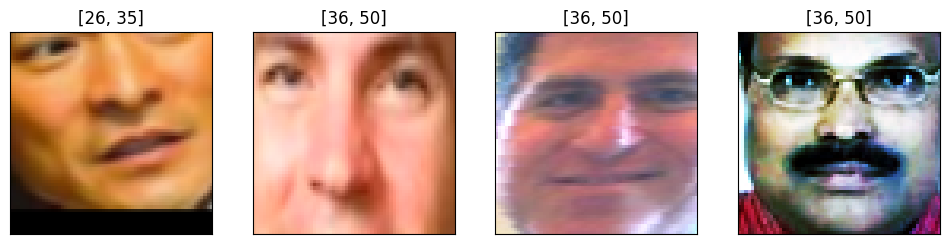

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False)

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, len(images), figsize=(12,10))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_image_format(image))
    axes[idx].set_title(classes[int(labels[idx])])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

# Implementation of ResNet9 basic architecture (with dropout layer).

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9_64(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Finding number of trainable weights in ResNet9 for 64x64 images

In [ ]:
IMAGE_SHAPE = (3, 64, 64)
dummy_input = torch.zeros([1, *IMAGE_SHAPE])
dummy_model = ResNet9_64(3, len(classes))
dummy_model.eval()
dummy_output = dummy_model(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# calculating the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

torch.Size([1, 6])
torch.Size([1, 6])
num trainable weights:  7622406


# Implementing early stopping.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model, epoch)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch):
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
        torch.save(state, self.path)
        self.best_score = val_loss


# Create directory and all other folders for ResNet9_64

In [ ]:
os.makedirs(os.path.join(drive_dir, "architectures", 'ResNet9_64'), exist_ok=True)
os.makedirs(os.path.join(drive_dir, "architectures", 'ResNet9_64', 'intermediate_checkpoints'), exist_ok=True)
root_path = os.path.join(drive_dir, "architectures", 'ResNet9_64')
print(root_path)

/content/drive/MyDrive/architectures/ResNet9_64


# Now onto the training and testing of the ResNet9 architecture.

In [ ]:
batch_size = 128
max_learning_rate = 0.001
weight_decay = 1e-4
epochs = 50

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# model
model = ResNet9_64(IMAGE_SHAPE[0], len(classes)).to(device)

# optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(trainloader))

# early stopping policy
early_stopping = EarlyStopping(path=os.path.join(root_path, 'early_stopped_model.pth'))
print(os.path.join(root_path, 'intermediate_checkpoints', 'early_stopped_model.pth'))

/content/drive/MyDrive/architectures/ResNet9_64/intermediate_checkpoints/early_stopped_model.pth


### Function to calculate accuracy for a different epoch.

In [ ]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([len(classes),len(classes)], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # import pdb; pdb.set_trace()
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [ ]:
# training loop
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # append the losses
    loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # modify learning rate
    scheduler.step()

    # save every 5 models
    if epoch % 5 == 0:
      print('==> Saving model ...')
      state = {
          'net': model.state_dict(),
          'epoch': epoch,
      }

      torch.save(state, os.path.join(root_path, 'intermediate_checkpoints', f'model_epoch_{epoch}.pth'))

    # compute validation loss to check if we should stop
    model.eval()  # switch to evaluation mode
    test_loss = 0.0
    total_test_samples = 0

    with torch.no_grad():  # No need to compute gradients during validation
      for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update validation loss and total samples
        test_loss += loss.item() * inputs.size(0)
        total_test_samples += inputs.size(0)

    # Calculate average validation loss
    test_loss /= total_test_samples

    log = "Epoch: {} | Training Loss: {:.4f} | Test Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, test_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    early_stopping(test_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping")
        break

EXP_COUNTER += 1
print('==> Finished Training ...')

Epoch: 1 | Training Loss: 1.7420 | Test Loss: 1.6435 | Training accuracy: 34.297% | Test accuracy: 34.481% | Epoch Time: 78.71 secs
Epoch: 2 | Training Loss: 1.6610 | Test Loss: 1.6214 | Training accuracy: 34.139% | Test accuracy: 34.444% | Epoch Time: 79.41 secs
Epoch: 3 | Training Loss: 1.6450 | Test Loss: 1.6098 | Training accuracy: 34.390% | Test accuracy: 34.835% | Epoch Time: 79.54 secs
Epoch: 4 | Training Loss: 1.6346 | Test Loss: 1.5757 | Training accuracy: 34.469% | Test accuracy: 35.301% | Epoch Time: 79.13 secs
==> Saving model ...
Epoch: 5 | Training Loss: 1.6259 | Test Loss: 1.6221 | Training accuracy: 34.283% | Test accuracy: 33.588% | Epoch Time: 79.00 secs
Epoch: 6 | Training Loss: 1.6178 | Test Loss: 1.5230 | Training accuracy: 34.884% | Test accuracy: 37.442% | Epoch Time: 79.32 secs
Epoch: 7 | Training Loss: 1.6005 | Test Loss: 1.5000 | Training accuracy: 35.014% | Test accuracy: 38.093% | Epoch Time: 80.95 secs
Epoch: 8 | Training Loss: 1.5878 | Test Loss: 1.4954 | 

# Plot loss, train acc vs valid acc

39


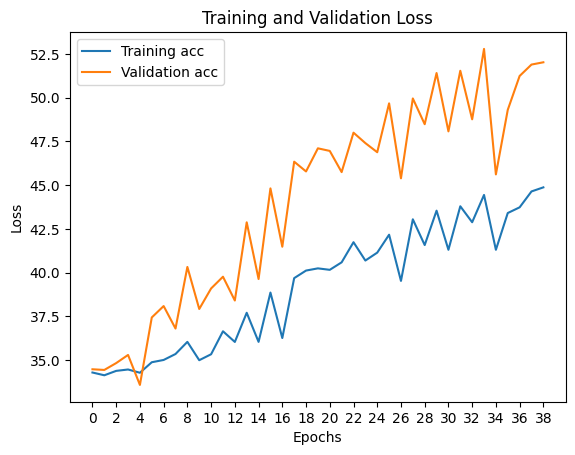

In [ ]:
# Plot and label the training and validation loss values
print(len(train_acc_list))
epochs_list = list(range(epochs))
plt.plot(epochs_list[:len(train_acc_list)], train_acc_list, label='Training acc')
plt.plot(epochs_list[:len(train_acc_list)], test_acc_list, label='Validation acc')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, len(train_acc_list), 2))

# Display the plot
plt.legend(loc='best')
plt.savefig(os.path.join(root_path, "loss_plot.png"))
plt.show()

In [ ]:
best_model = ResNet9_64(3, len(classes))  # Modify with your model architecture

# Load the saved model state dictionary
checkpoint = torch.load(os.path.join(root_path, 'early_stopped_model.pth'))

# Load the model state dictionary
best_model.load_state_dict(checkpoint['net'])
best_model.to(device)

transform_testing_purposes = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

# Create a DataLoader for the training set without data augmentation
trainloader_no_aug = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_for_testing = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

no_aug_train_acc, confusion_matrix_train = calculate_accuracy(best_model, trainloader_no_aug, device)
test_acc, confusion_matrix_test = calculate_accuracy(best_model, testloader_for_testing, device)

print(f"Accuracy on Training Set: {no_aug_train_acc}%")
print(f"Accuracy on Test Set: {test_acc}%")

Accuracy on Training Set: 53.575418994413404%
Accuracy on Test Set: 52.78346676596537%


In [ ]:
np.save(os.path.join(root_path, 'confusion_matrix_test.npy'), confusion_matrix_test)

np.save(os.path.join(root_path, 'confusion_matrix_train.npy'), confusion_matrix_test)

# Implementation of ResNet9 for 64x64 images without dropout, and without image augmentations.

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9_64_nodropout(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
IMAGE_SHAPE = (3, 64, 64)

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
)

# Now onto the actual training of the ResNet9 64x64 without dropout or image augmentations.

In [ ]:
root_path = os.path.join(drive_dir, "architectures", 'ResNet9_64_no_dropout')
os.makedirs(root_path, exist_ok=True)
os.makedirs(os.path.join(root_path, 'intermediate_checkpoints'), exist_ok=True)
print(root_path)

/content/drive/MyDrive/architectures/ResNet9_64_no_dropout


In [ ]:
batch_size = 128
max_learning_rate = 0.001
weight_decay = 1e-4
epochs = 50

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# model
model = ResNet9_64_nodropout(IMAGE_SHAPE[0], len(classes)).to(device)

# optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(trainloader))

# early stopping policy
early_stopping = EarlyStopping(path=os.path.join(root_path, 'early_stopped_model.pth'))
print(os.path.join(root_path, 'intermediate_checkpoints', 'early_stopped_model.pth'))

/content/drive/MyDrive/architectures/ResNet9_64_no_dropout/intermediate_checkpoints/early_stopped_model.pth


In [ ]:
# training loop
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # append the losses
    loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # modify learning rate
    scheduler.step()

    # save every 5 models
    if epoch % 5 == 0:
      print('==> Saving model ...')
      state = {
          'net': model.state_dict(),
          'epoch': epoch,
      }

      torch.save(state, os.path.join(root_path, 'intermediate_checkpoints', f'model_epoch_{epoch}.pth'))

    # compute validation loss to check if we should stop
    model.eval()  # switch to evaluation mode
    test_loss = 0.0
    total_test_samples = 0

    with torch.no_grad():  # No need to compute gradients during validation
      for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update validation loss and total samples
        test_loss += loss.item() * inputs.size(0)
        total_test_samples += inputs.size(0)

    # Calculate average validation loss
    test_loss /= total_test_samples

    log = "Epoch: {} | Training Loss: {:.4f} | Test Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, test_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    early_stopping(test_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping")
        break

EXP_COUNTER += 1
print('==> Finished Training ...')

Epoch: 1 | Training Loss: 1.2749 | Test Loss: 1.3137 | Training accuracy: 54.455% | Test accuracy: 43.232% | Epoch Time: 35.43 secs
Epoch: 2 | Training Loss: 1.1180 | Test Loss: 1.2463 | Training accuracy: 60.992% | Test accuracy: 46.546% | Epoch Time: 34.75 secs
Epoch: 3 | Training Loss: 0.9683 | Test Loss: 1.1807 | Training accuracy: 68.478% | Test accuracy: 49.246% | Epoch Time: 34.85 secs
Epoch: 4 | Training Loss: 0.8149 | Test Loss: 1.1508 | Training accuracy: 79.879% | Test accuracy: 50.251% | Epoch Time: 33.63 secs
==> Saving model ...
Epoch: 5 | Training Loss: 0.6377 | Test Loss: 1.1807 | Training accuracy: 85.861% | Test accuracy: 49.842% | Epoch Time: 37.32 secs
Epoch: 6 | Training Loss: 0.4614 | Test Loss: 1.1628 | Training accuracy: 96.792% | Test accuracy: 49.842% | Epoch Time: 34.57 secs
Epoch: 7 | Training Loss: 0.2961 | Test Loss: 1.1917 | Training accuracy: 99.171% | Test accuracy: 50.251% | Epoch Time: 35.16 secs
Epoch: 8 | Training Loss: 0.1810 | Test Loss: 1.3264 | 

# Now onto ResNet9 but with images of shape 128x128.

In [ ]:
class ResNet9_128(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(8192, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
IMAGE_SHAPE = (3, 128, 128)
dummy_input = torch.zeros([1, *IMAGE_SHAPE])
dummy_model = ResNet9_128(3, len(classes))
dummy_model.eval()
dummy_output = dummy_model(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# calculating the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

torch.Size([1, 6])
torch.Size([1, 6])
num trainable weights:  10768134


In [ ]:
root_path = os.path.join(drive_dir, "architectures", 'ResNet9_128')
os.makedirs(root_path, exist_ok=True)
os.makedirs(os.path.join(root_path, 'intermediate_checkpoints'), exist_ok=True)
print(root_path)


/content/drive/MyDrive/architectures/ResNet9_128


In [ ]:
batch_size = 128
max_learning_rate = 0.001
weight_decay = 1e-4
epochs = 50

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_train,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_test,
)

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# model
model = ResNet9_128(IMAGE_SHAPE[0], len(classes)).to(device)

# optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(trainloader))

# early stopping policy
early_stopping = EarlyStopping(path=os.path.join(root_path, 'early_stopped_model.pth'))
print(os.path.join(root_path, 'intermediate_checkpoints', 'early_stopped_model.pth'))

/content/drive/MyDrive/architectures/ResNet9_128/intermediate_checkpoints/early_stopped_model.pth


In [ ]:
# training loop
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # append the losses
    loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # modify learning rate
    scheduler.step()

    # save every 5 models
    if epoch % 5 == 0:
      print('==> Saving model ...')
      state = {
          'net': model.state_dict(),
          'epoch': epoch,
      }

      torch.save(state, os.path.join(root_path, 'intermediate_checkpoints', f'model_epoch_{epoch}.pth'))

    # compute validation loss to check if we should stop
    model.eval()  # switch to evaluation mode
    test_loss = 0.0
    total_test_samples = 0

    with torch.no_grad():  # No need to compute gradients during validation
      for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update validation loss and total samples
        test_loss += loss.item() * inputs.size(0)
        total_test_samples += inputs.size(0)

    # Calculate average validation loss
    test_loss /= total_test_samples

    log = "Epoch: {} | Training Loss: {:.4f} | Test Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, test_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    early_stopping(test_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping")
        break

EXP_COUNTER += 1
print('==> Finished Training ...')

Epoch: 1 | Training Loss: 1.6816 | Test Loss: 1.5947 | Training accuracy: 34.334% | Test accuracy: 34.500% | Epoch Time: 47.10 secs
Epoch: 2 | Training Loss: 1.6336 | Test Loss: 1.5608 | Training accuracy: 34.548% | Test accuracy: 35.748% | Epoch Time: 46.81 secs
Epoch: 3 | Training Loss: 1.6197 | Test Loss: 1.5079 | Training accuracy: 34.711% | Test accuracy: 37.218% | Epoch Time: 46.95 secs
Epoch: 4 | Training Loss: 1.6065 | Test Loss: 1.4916 | Training accuracy: 35.098% | Test accuracy: 37.963% | Epoch Time: 47.11 secs
==> Saving model ...
Epoch: 5 | Training Loss: 1.5856 | Test Loss: 1.4442 | Training accuracy: 35.484% | Test accuracy: 38.373% | Epoch Time: 47.16 secs
Epoch: 6 | Training Loss: 1.5756 | Test Loss: 1.4166 | Training accuracy: 36.667% | Test accuracy: 39.899% | Epoch Time: 47.07 secs
Epoch: 7 | Training Loss: 1.5505 | Test Loss: 1.4307 | Training accuracy: 36.453% | Test accuracy: 39.155% | Epoch Time: 46.91 secs
Epoch: 8 | Training Loss: 1.5374 | Test Loss: 1.4358 | 

# Since the model did not converge, train for 50 more epochs, the same as before.

In [ ]:
# Define the number of additional epochs you want to train for
additional_epochs = 50

# Continue training for additional_epochs
for epoch in range(epochs + 1, epochs + additional_epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # append the losses
    loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # modify learning rate
    scheduler.step()

    # save every 5 models
    if epoch % 5 == 0:
      print('==> Saving model ...')
      state = {
          'net': model.state_dict(),
          'epoch': epoch,
      }

      torch.save(state, os.path.join(root_path, 'intermediate_checkpoints', f'model_epoch_{epoch}.pth'))

    # compute validation loss to check if we should stop
    model.eval()  # switch to evaluation mode
    test_loss = 0.0
    total_test_samples = 0

    with torch.no_grad():  # No need to compute gradients during validation
      for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update validation loss and total samples
        test_loss += loss.item() * inputs.size(0)
        total_test_samples += inputs.size(0)

    # Calculate average validation loss
    test_loss /= total_test_samples

    log = "Epoch: {} | Training Loss: {:.4f} | Test Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, test_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    early_stopping(test_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Update the total number of epochs
epochs += additional_epochs
print('==> Finished Training ...')


Epoch: 51 | Training Loss: 1.2956 | Test Loss: 1.0775 | Training accuracy: 46.965% | Test accuracy: 52.020% | Epoch Time: 48.17 secs
Epoch: 52 | Training Loss: 1.2929 | Test Loss: 1.0855 | Training accuracy: 46.224% | Test accuracy: 52.206% | Epoch Time: 48.27 secs
Epoch: 53 | Training Loss: 1.2789 | Test Loss: 1.0691 | Training accuracy: 46.550% | Test accuracy: 52.765% | Epoch Time: 48.16 secs
Epoch: 54 | Training Loss: 1.2870 | Test Loss: 1.1172 | Training accuracy: 45.628% | Test accuracy: 51.797% | Epoch Time: 48.05 secs
==> Saving model ...
Epoch: 55 | Training Loss: 1.2839 | Test Loss: 1.1104 | Training accuracy: 44.739% | Test accuracy: 51.220% | Epoch Time: 48.31 secs
Epoch: 56 | Training Loss: 1.2811 | Test Loss: 1.0544 | Training accuracy: 46.653% | Test accuracy: 52.914% | Epoch Time: 48.12 secs
Epoch: 57 | Training Loss: 1.2786 | Test Loss: 1.1053 | Training accuracy: 45.587% | Test accuracy: 50.884% | Epoch Time: 48.33 secs
Epoch: 58 | Training Loss: 1.2758 | Test Loss: 1

97


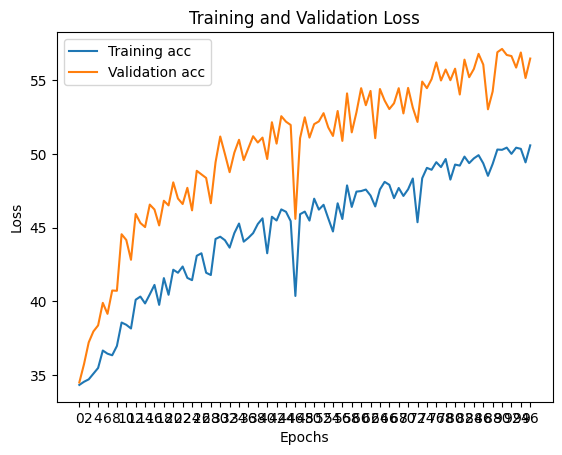

In [ ]:
# Plot and label the training and validation loss values
print(len(train_acc_list))
epochs_list = list(range(epochs))
plt.plot(epochs_list[:len(train_acc_list)], train_acc_list, label='Training acc')
plt.plot(epochs_list[:len(train_acc_list)], test_acc_list, label='Validation acc')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, len(train_acc_list), 2))

# Display the plot
plt.legend(loc='best')
plt.savefig(os.path.join(root_path, "loss_plot.png"))
plt.show()

In [ ]:
best_model = ResNet9_128(3, len(classes))

# Load the saved model state dictionary
checkpoint = torch.load(os.path.join(root_path, 'early_stopped_model.pth'))

# Load the model state dictionary
best_model.load_state_dict(checkpoint['net'])
best_model.to(device)

transform_testing_purposes = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

# Create a DataLoader for the training set without data augmentation
trainloader_no_aug = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_for_testing = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

no_aug_train_acc, confusion_matrix_train = calculate_accuracy(best_model, trainloader_no_aug, device)
test_acc, confusion_matrix_test = calculate_accuracy(best_model, testloader_for_testing, device)

print(f"Accuracy on Training Set: {no_aug_train_acc}%")
print(f"Accuracy on Test Set: {test_acc}%")

Accuracy on Training Set: 59.729981378026075%
Accuracy on Test Set: 56.711971699869665%


In [ ]:
np.save(os.path.join(root_path, 'confusion_matrix_test.npy'), confusion_matrix_test)
np.save(os.path.join(root_path, 'confusion_matrix_train.npy'), confusion_matrix_test)

# Now onto training ResNet50, with Dropout.

In [ ]:
class ResNet50_Dropout(nn.Module):
    def __init__(self, num_classes=6, dropout_prob=0.5):
        super(ResNet50_Dropout, self).__init__()
        self.resnet50 = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)

        # Modify the last fully connected layer to output predictions for 6 classes
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)


In [ ]:
IMAGE_SHAPE = (3, 224, 224)
dummy_input = torch.zeros([1, *IMAGE_SHAPE])
dummy_model = ResNet50_Dropout(len(classes))
dummy_model.eval()
dummy_output = dummy_model(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# calculating the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


torch.Size([1, 6])
torch.Size([1, 6])
num trainable weights:  24560198


In [ ]:
root_path = os.path.join(drive_dir, "architectures", 'ResNet50_Dropout')
os.makedirs(root_path, exist_ok=True)
os.makedirs(os.path.join(root_path, 'intermediate_checkpoints'), exist_ok=True)
print(root_path)

/content/drive/MyDrive/architectures/ResNet50_Dropout


In [ ]:
batch_size = 128
max_learning_rate = 0.001
weight_decay = 1e-4
epochs = 50

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_train,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_test,
)

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# model
model = ResNet50_Dropout(len(classes)).to(device)

# optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(trainloader))

# early stopping policy
early_stopping = EarlyStopping(path=os.path.join(root_path, 'early_stopped_model.pth'))
print(os.path.join(root_path, 'intermediate_checkpoints', 'early_stopped_model.pth'))

/content/drive/MyDrive/architectures/ResNet50_Dropout/intermediate_checkpoints/early_stopped_model.pth


In [ ]:
# training loop
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
curr_minimum_loss = 10000

for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # append the losses
    train_loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # modify learning rate
    scheduler.step()

    # compute validation loss to check if we should stop
    model.eval()  # switch to evaluation mode
    test_loss = 0.0
    total_test_samples = 0

    with torch.no_grad():  # No need to compute gradients during validation
      for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update validation loss and total samples
        test_loss += loss.item() * inputs.size(0)
        total_test_samples += inputs.size(0)

    # Calculate average validation loss
    test_loss /= total_test_samples
    test_loss_list.append(test_loss)

    log = "Epoch: {} | Training Loss: {:.4f} | Test Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, test_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, os.path.join(root_path, f'model_{epoch}.pth'))

    if test_loss < curr_minimum_loss:
      curr_minimum_loss = test_loss
      torch.save(state, os.path.join(root_path, 'best_model.pth'))

EXP_COUNTER += 1
print('==> Finished Training ...')

Epoch: 1 | Training Loss: 1.5942 | Test Loss: 1.4373 | Training accuracy: 36.294% | Test accuracy: 39.899% | Epoch Time: 98.68 secs
Epoch: 2 | Training Loss: 1.4381 | Test Loss: 1.2470 | Training accuracy: 42.612% | Test accuracy: 46.751% | Epoch Time: 98.35 secs
Epoch: 3 | Training Loss: 1.3273 | Test Loss: 1.1526 | Training accuracy: 45.912% | Test accuracy: 49.898% | Epoch Time: 97.79 secs
Epoch: 4 | Training Loss: 1.2666 | Test Loss: 1.0958 | Training accuracy: 48.347% | Test accuracy: 52.895% | Epoch Time: 98.64 secs
Epoch: 5 | Training Loss: 1.2239 | Test Loss: 1.0741 | Training accuracy: 48.785% | Test accuracy: 53.547% | Epoch Time: 97.89 secs
Epoch: 6 | Training Loss: 1.1891 | Test Loss: 1.0477 | Training accuracy: 50.172% | Test accuracy: 55.036% | Epoch Time: 98.42 secs
Epoch: 7 | Training Loss: 1.1584 | Test Loss: 1.0082 | Training accuracy: 52.197% | Test accuracy: 56.656% | Epoch Time: 98.24 secs
Epoch: 8 | Training Loss: 1.1376 | Test Loss: 0.9963 | Training accuracy: 53

KeyboardInterrupt: 

32


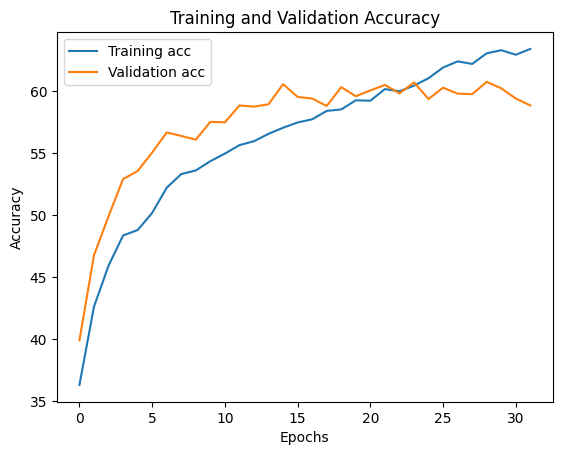

In [ ]:
# Plot and label the training and validation loss values
print(len(train_acc_list))
epochs_list = list(range(epochs))
plt.plot(epochs_list[:len(train_acc_list)], train_acc_list, label='Training acc')
plt.plot(epochs_list[:len(train_acc_list)], test_acc_list, label='Validation acc')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(0, len(train_acc_list), 5))

# Display the plot
plt.legend(loc='best')
plt.savefig(os.path.join(root_path, "acc_plot.png"), format='pdf')
plt.show()

In [ ]:
best_model = ResNet50_Dropout(len(classes), 0.5)

# Load the saved model state dictionary
checkpoint = torch.load(os.path.join(root_path, 'model_29.pth'))
print(checkpoint['epoch'])

# Load the model state dictionary
best_model.load_state_dict(checkpoint['net'])
best_model.to(device)

transform_testing_purposes = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

# Create a DataLoader for the training set without data augmentation
trainloader_no_aug = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_for_testing = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

no_aug_train_acc, confusion_matrix_train = calculate_accuracy(best_model, trainloader_no_aug, device)
test_acc, confusion_matrix_test = calculate_accuracy(best_model, testloader_for_testing, device)

print(f"Accuracy on Training Set: {no_aug_train_acc}%")
print(f"Accuracy on Test Set: {test_acc}%")

29
Accuracy on Training Set: 75.58659217877096%
Accuracy on Test Set: 60.73356916775274%


In [ ]:
np.save(os.path.join(root_path, 'confusion_matrix_test.npy'), confusion_matrix_test)
np.save(os.path.join(root_path, 'confusion_matrix_train.npy'), confusion_matrix_test)

# *FaceNet* pre-trained on vggface2

In [ ]:
root_path = os.path.join(drive_dir, "architectures", 'FaceNet')
os.makedirs(root_path, exist_ok=True)
os.makedirs(os.path.join(root_path, 'intermediate_checkpoints'), exist_ok=True)
print(root_path)
IMAGE_SHAPE = (3, 160, 160)

/content/drive/MyDrive/architectures/FaceNet


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
batch_size = 128
max_learning_rate = 0.001
weight_decay = 1e-4
epochs = 50

transform_train = transforms.Compose([
    transforms.RandAugment(2, 22),
    RandomBoundingBoxJitter(0.45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_train,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_test,
)

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# model
model = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(classes)).to(device)

# optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(trainloader))




In [ ]:
# training loop
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # append the losses
    loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # modify learning rate
    scheduler.step()

    # save every 5 models
    # we comment because the model stopped before 20 epochs, so need to train for full 50
    #if epoch % 5 == 0:
     # print('==> Saving model ...')
      #state = {
       #   'net': model.state_dict(),
        #  'epoch': epoch,
      #}

      #torch.save(state, os.path.join(root_path, 'intermediate_checkpoints', f'model_epoch_{epoch}.pth'))

    # compute validation loss to check if we should stop
    model.eval()  # switch to evaluation mode
    test_loss = 0.0
    total_test_samples = 0

    with torch.no_grad():  # No need to compute gradients during validation
      for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update validation loss and total samples
        test_loss += loss.item() * inputs.size(0)
        total_test_samples += inputs.size(0)

    # Calculate average validation loss
    test_loss /= total_test_samples

    log = "Epoch: {} | Training Loss: {:.4f} | Test Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, test_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, os.path.join(root_path, f'model_{epoch}.pth'))

EXP_COUNTER += 1
print('==> Finished Training ...')

Epoch: 1 | Training Loss: 1.4705 | Test Loss: 1.0218 | Training accuracy: 46.099% | Test accuracy: 56.321% | Epoch Time: 69.70 secs
Epoch: 2 | Training Loss: 1.2822 | Test Loss: 1.0625 | Training accuracy: 49.372% | Test accuracy: 57.103% | Epoch Time: 69.67 secs
Epoch: 3 | Training Loss: 1.2277 | Test Loss: 0.9964 | Training accuracy: 50.396% | Test accuracy: 58.909% | Epoch Time: 69.71 secs
Epoch: 4 | Training Loss: 1.1887 | Test Loss: 0.9318 | Training accuracy: 52.304% | Test accuracy: 60.901% | Epoch Time: 68.81 secs
Epoch: 5 | Training Loss: 1.1749 | Test Loss: 0.9494 | Training accuracy: 51.951% | Test accuracy: 60.398% | Epoch Time: 69.53 secs
Epoch: 6 | Training Loss: 1.1403 | Test Loss: 0.9101 | Training accuracy: 53.426% | Test accuracy: 61.962% | Epoch Time: 69.51 secs
Epoch: 7 | Training Loss: 1.1313 | Test Loss: 0.9291 | Training accuracy: 53.361% | Test accuracy: 59.877% | Epoch Time: 69.02 secs
Epoch: 8 | Training Loss: 1.1137 | Test Loss: 0.9102 | Training accuracy: 54

50


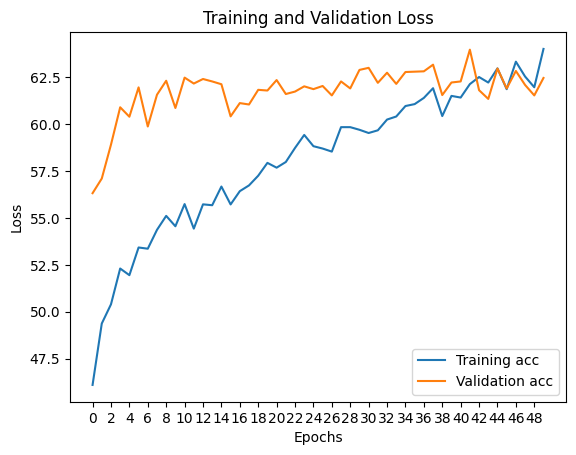

In [ ]:
# Plot and label the training and validation loss values
print(len(train_acc_list))
epochs_list = list(range(epochs))
plt.plot(epochs_list[:len(train_acc_list)], train_acc_list, label='Training acc')
plt.plot(epochs_list[:len(train_acc_list)], test_acc_list, label='Validation acc')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, len(train_acc_list), 2))

# Display the plot
plt.legend(loc='best')
plt.savefig(os.path.join(root_path, "loss_plot.png"))
plt.show()

In [ ]:
# Epoch: 42 | Training Loss: 0.9267 | Test Loss: 0.8981 | Training accuracy: 62.137% | Test accuracy: 63.973% | Epoch Time: 68.93 secs

best_model = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(classes)).to(device)

# Load the saved model state dictionary
checkpoint = torch.load(os.path.join(root_path, 'model_42.pth'))

# Load the model state dictionary
best_model.load_state_dict(checkpoint['net'])
best_model.to(device)

transform_testing_purposes = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

# Create a DataLoader for the training set without data augmentation
trainloader_no_aug = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_for_testing = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

no_aug_train_acc, confusion_matrix_train = calculate_accuracy(best_model, trainloader_no_aug, device)
test_acc, confusion_matrix_test = calculate_accuracy(best_model, testloader_for_testing, device)

print(f"Accuracy on Training Set: {no_aug_train_acc}%")
print(f"Accuracy on Test Set: {test_acc}%")

Accuracy on Training Set: 79.78584729981378%
Accuracy on Test Set: 63.97318935021411%


In [ ]:
np.save(os.path.join(root_path, 'confusion_matrix_test.npy'), confusion_matrix_test)
np.save(os.path.join(root_path, 'confusion_matrix_train.npy'), confusion_matrix_test)

# FaceNet on CasiaFace

In [ ]:
root_path = os.path.join(drive_dir, "architectures", 'FaceNet_Casia')
os.makedirs(root_path, exist_ok=True)
os.makedirs(os.path.join(root_path, 'intermediate_checkpoints'), exist_ok=True)
print(root_path)
IMAGE_SHAPE = (3, 160, 160)

/content/drive/MyDrive/architectures/FaceNet_Casia


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
batch_size = 128
max_learning_rate = 0.001
weight_decay = 1e-4
epochs = 50

transform_train = transforms.Compose([
    transforms.RandAugment(2, 22),
    RandomBoundingBoxJitter(0.45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_train,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_test,
)

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# model
model = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=len(classes)).to(device)

# optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(trainloader))

  0%|          | 0.00/111M [00:00<?, ?B/s]

In [ ]:
# training loop
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    # append the losses
    loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # modify learning rate
    scheduler.step()

    # save every 5 models
    #if epoch % 5 == 0:
     # print('==> Saving model ...')
      #state = {
       #   'net': model.state_dict(),
        #  'epoch': epoch,
      #}

      #torch.save(state, os.path.join(root_path, 'intermediate_checkpoints', f'model_epoch_{epoch}.pth'))

    # compute validation loss to check if we should stop
    model.eval()  # switch to evaluation mode
    test_loss = 0.0
    total_test_samples = 0

    with torch.no_grad():  # No need to compute gradients during validation
      for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update validation loss and total samples
        test_loss += loss.item() * inputs.size(0)
        total_test_samples += inputs.size(0)

    # Calculate average validation loss
    test_loss /= total_test_samples

    log = "Epoch: {} | Training Loss: {:.4f} | Test Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, test_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, os.path.join(root_path, f'model_{epoch}.pth'))

EXP_COUNTER += 1
print('==> Finished Training ...')

Epoch: 1 | Training Loss: 1.5721 | Test Loss: 1.1666 | Training accuracy: 44.972% | Test accuracy: 53.416% | Epoch Time: 69.70 secs
Epoch: 2 | Training Loss: 1.3598 | Test Loss: 1.0350 | Training accuracy: 47.118% | Test accuracy: 57.159% | Epoch Time: 69.43 secs
Epoch: 3 | Training Loss: 1.2954 | Test Loss: 1.0146 | Training accuracy: 48.873% | Test accuracy: 58.406% | Epoch Time: 69.06 secs
Epoch: 4 | Training Loss: 1.2523 | Test Loss: 0.9877 | Training accuracy: 49.781% | Test accuracy: 58.350% | Epoch Time: 69.65 secs
Epoch: 5 | Training Loss: 1.2285 | Test Loss: 0.9891 | Training accuracy: 50.112% | Test accuracy: 58.146% | Epoch Time: 68.20 secs
Epoch: 6 | Training Loss: 1.2201 | Test Loss: 0.9835 | Training accuracy: 50.051% | Test accuracy: 59.542% | Epoch Time: 65.47 secs
Epoch: 7 | Training Loss: 1.1911 | Test Loss: 0.9951 | Training accuracy: 50.386% | Test accuracy: 58.443% | Epoch Time: 65.89 secs
Epoch: 8 | Training Loss: 1.1781 | Test Loss: 0.9404 | Training accuracy: 52

50


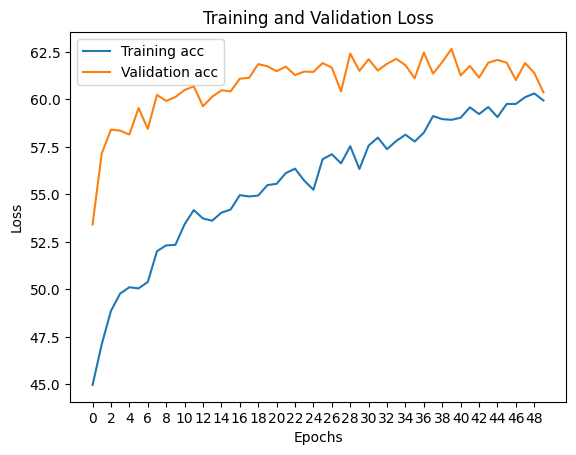

In [ ]:
# Plot and label the training and validation loss values
print(len(train_acc_list))
epochs_list = list(range(epochs))
plt.plot(epochs_list[:len(train_acc_list)], train_acc_list, label='Training acc')
plt.plot(epochs_list[:len(train_acc_list)], test_acc_list, label='Validation acc')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, len(train_acc_list), 2))

# Display the plot
plt.legend(loc='best')
plt.savefig(os.path.join(root_path, "loss_plot.png"))
plt.show()

In [ ]:
# Epoch: 40 | Training Loss: 0.9947 | Test Loss: 0.8843 | Training accuracy: 58.920% | Test accuracy: 62.651% | Epoch Time: 66.28 secs

best_model = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=len(classes)).to(device)

# Load the saved model state dictionary
checkpoint = torch.load(os.path.join(root_path, 'model_40.pth'))

# Load the model state dictionary
best_model.load_state_dict(checkpoint['net'])
best_model.to(device)

transform_testing_purposes = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
    augmentations=transform_testing_purposes,
)

# Create a DataLoader for the training set without data augmentation
trainloader_no_aug = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_for_testing = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

no_aug_train_acc, confusion_matrix_train = calculate_accuracy(best_model, trainloader_no_aug, device)
test_acc, confusion_matrix_test = calculate_accuracy(best_model, testloader_for_testing, device)

print(f"Accuracy on Training Set: {no_aug_train_acc}%")
print(f"Accuracy on Test Set: {test_acc}%")

Accuracy on Training Set: 73.81284916201118%
Accuracy on Test Set: 62.651275367715506%


In [ ]:
np.save(os.path.join(root_path, 'confusion_matrix_test.npy'), confusion_matrix_test)
np.save(os.path.join(root_path, 'confusion_matrix_train.npy'), confusion_matrix_train)